In [1]:
!pip install -q timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 36.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.2 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installe

In [2]:
# Cell 1
import os, random, math, gc, glob, sys, time
from collections import Counter
import numpy as np
import pandas as pd
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True  # tolerate truncated images
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, precision_recall_fscore_support

# reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

# User-tweakable config
KAGGLE_INPUT_DIR = "/kaggle/input/breast-histopathology-images"  # update if different
WORK_DIR = "/kaggle/working"
IMG_SIZE = 224
SMOKE_TEST = False   # set True for quick sanity check, False to run full dataset
SMOKE_SLIDES_PER_CLASS = 2  # when smoke testing: slides per class
MODEL_NAME = "convnext_tiny"  
BASE_LR = 5e-5
WEIGHT_DECAY = 0.01
NUM_WORKERS = 4
PIN_MEMORY = True

# --- MOVED EPOCHS HERE ---
EPOCHS = 30 if not SMOKE_TEST else 1

# Accelerator detection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpus = torch.cuda.device_count()
print("Device:", device, "GPUs:", n_gpus)
for i in range(n_gpus):
    try:
        print(i, torch.cuda.get_device_name(i), torch.cuda.get_device_properties(i).total_memory/1024**3, "GB")
    except:
        pass


/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

Device: cuda GPUs: 2
0 Tesla T4 14.74127197265625 GB
1 Tesla T4 14.74127197265625 GB


In [3]:
# Cell 2: build df with columns: slide_id, image_path, class
rows = []
root = KAGGLE_INPUT_DIR
assert os.path.exists(root), f"Dataset path not found: {root}"

# Detect layout: (A) slide_id subfolders each containing class subfolders, or
# (B) flat folder with filenames containing '_class0' / '_class1'
top = sorted(os.listdir(root))
if len(top) == 0:
    raise RuntimeError("Empty dataset directory")
# Heuristic: check if first entry is numeric slide folder containing class subfolders
first = top[0]
first_path = os.path.join(root, first)
if os.path.isdir(first_path) and any(os.path.isdir(os.path.join(first_path, d)) for d in os.listdir(first_path)):
    # layout A
    for slide_id in sorted(os.listdir(root)):
        slide_dir = os.path.join(root, slide_id)
        if not os.path.isdir(slide_dir): continue
        for cls_name in sorted(os.listdir(slide_dir)):
            cls_dir = os.path.join(slide_dir, cls_name)
            if not os.path.isdir(cls_dir): continue
            for fname in os.listdir(cls_dir):
                if fname.lower().endswith((".png", ".jpg", ".jpeg")):
                    rows.append({"slide_id": slide_id, "image_path": os.path.join(cls_dir, fname), "class": int(cls_name)})
else:
    # layout B (flat); parse filenames
    for fname in sorted(os.listdir(root)):
        if not fname.lower().endswith((".png", ".jpg", ".jpeg")): continue
        cls = 1 if "_class1" in fname else 0
        slide_id = fname.split("_")[0]
        rows.append({"slide_id": slide_id, "image_path": os.path.join(root, fname), "class": int(cls)})

df = pd.DataFrame(rows)
print("Total images:", len(df))
print("Class distribution (image-level):\n", df['class'].value_counts())
# compute slide-level majority label
slide_label = df.groupby('slide_id')['class'].agg(lambda x: x.mode().iloc[0]).reset_index().rename(columns={'class':'slide_class'})
print("Total slides:", len(slide_label), "Slide class counts:\n", slide_label['slide_class'].value_counts())

# Optionally reduce dataset for smoke test
if SMOKE_TEST:
    keep_slides = []
    for c in [0,1]:
        slides_of_c = slide_label[slide_label['slide_class']==c]['slide_id'].tolist()
        keep_slides += slides_of_c[:SMOKE_SLIDES_PER_CLASS]
    df = df[df['slide_id'].isin(keep_slides)].reset_index(drop=True)
    slide_label = slide_label[slide_label['slide_id'].isin(keep_slides)].reset_index(drop=True)
    print("Smoke test mode: reduced images:", len(df), "slides:", len(slide_label))


Total images: 277524
Class distribution (image-level):
 class
0    198738
1     78786
Name: count, dtype: int64
Total slides: 279 Slide class counts:
 slide_class
0    218
1     61
Name: count, dtype: int64


In [4]:
# --- REPLACE Cell 3 with this robust slide-level split (paste this cell) ---
from collections import defaultdict
import math

slides = slide_label['slide_id'].tolist()
slide_y = slide_label.set_index('slide_id')['slide_class'].to_dict()
n_slides = len(slides)
n_classes = slide_label['slide_class'].nunique()
print(f"Total slides={n_slides}, classes={n_classes}")

# helper to shuffle while keeping reproducibility
rng = random.Random(SEED)
slides_shuffled = slides.copy()
rng.shuffle(slides_shuffled)

# Normal case: enough slides to do a stratified split safely
if n_slides >= max(10, n_classes * 5):
    train_slides, valtest_slides = train_test_split(
        slides_shuffled, test_size=0.2, stratify=[slide_y[s] for s in slides_shuffled], random_state=SEED
    )
    val_slides, test_slides = train_test_split(
        valtest_slides, test_size=0.5, stratify=[slide_y[s] for s in valtest_slides], random_state=SEED
    )
else:
    # Small dataset: do a careful per-class allocation to avoid empty stratified buckets
    slides_by_class = defaultdict(list)
    for s in slides_shuffled:
        slides_by_class[slide_y[s]].append(s)

    train_slides = []
    val_slides = []
    test_slides = []

    # For each class, allocate slides: prefer (train, val, test) = (rest, 1, 1) when possible.
    for c, s_list in slides_by_class.items():
        rng.shuffle(s_list)
        if len(s_list) >= 3:
            # leave most in train, reserve 1 val, 1 test
            val_slides.append(s_list[0])
            test_slides.append(s_list[1])
            train_slides.extend(s_list[2:])
        elif len(s_list) == 2:
            # reserve one for val and one for train (or val+test)
            val_slides.append(s_list[0])
            test_slides.append(s_list[1])
        elif len(s_list) == 1:
            # only one slide for this class -> put it in train (can't fill val/test)
            train_slides.append(s_list[0])

    # If we ended up with empty val/test but overall slides allow it, move some from train
    # Ensure val and test have at least 1 slide each if we have >=2 slides total
    def ensure_minimum(target_list, source_list, target_name):
        if len(target_list) == 0 and len(source_list) > 1:
            # move one from source to target
            moved = source_list.pop(0)
            target_list.append(moved)
            print(f"Moved slide {moved} from train to {target_name} to ensure non-empty split.")

    # Rebalance if necessary
    ensure_minimum(val_slides, train_slides, 'val')
    ensure_minimum(test_slides, train_slides, 'test')

    # Final fallback: if train is empty (very tiny total slides), do a simple deterministic split
    if len(train_slides) == 0:
        s = slides_shuffled
        if n_slides == 1:
            train_slides = [s[0]]
            val_slides = []
            test_slides = []
        elif n_slides == 2:
            train_slides = [s[0]]
            val_slides = [s[1]]
            test_slides = []
        elif n_slides == 3:
            train_slides = [s[0]]
            val_slides = [s[1]]
            test_slides = [s[2]]
        elif n_slides == 4:
            train_slides = [s[0], s[1]]
            val_slides = [s[2]]
            test_slides = [s[3]]
        else:
            # as a last fallback, 60/20/20
            k_valtest = max(n_classes*2, int(round(0.2 * n_slides)))
            train_slides, valtest_slides = train_test_split(s, test_size=k_valtest, stratify=[slide_y[x] for x in s], random_state=SEED)
            val_slides, test_slides = train_test_split(valtest_slides, test_size=0.5, stratify=[slide_y[x] for x in valtest_slides], random_state=SEED)

# Build dataframes from chosen slide lists
train_df = df[df['slide_id'].isin(train_slides)].reset_index(drop=True)
val_df   = df[df['slide_id'].isin(val_slides)].reset_index(drop=True)
test_df  = df[df['slide_id'].isin(test_slides)].reset_index(drop=True)

print("Slides selected — train/val/test:", len(train_slides), len(val_slides), len(test_slides))
print("Images selected  — train/val/test:", len(train_df), len(val_df), len(test_df))

# Ensure no overlap
assert set(train_slides).isdisjoint(set(val_slides)), "train/val overlap!"
assert set(train_slides).isdisjoint(set(test_slides)), "train/test overlap!"
assert set(val_slides).isdisjoint(set(test_slides)), "val/test overlap!"
print("No slide overlap across splits ")


Total slides=279, classes=2
Slides selected — train/val/test: 223 28 28
Images selected  — train/val/test: 218468 25678 33378
No slide overlap across splits 


In [5]:
# === REPLACE Cell 4: Heavy Data Augmentation ===
from torchvision import transforms

# Stronger training transforms to prevent overfitting
train_transform = transforms.Compose([
    # 1. Geometric Transforms (Shapes)
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.7, 1.0)), # Zoom in/out more aggressively
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(180), # Full rotation allowed
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), shear=10, scale=(0.9, 1.1)), # Shift and squeeze

    # 2. Color/Blur Transforms (Texture/Stain variation)
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # Simulate stain variation
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)), # Simulate out-of-focus patches

    # 3. Normalization
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Validation remains simple (we want to test on "clean" images)
val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

class HistPatchDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        p = row['image_path']
        try:
            img = Image.open(p).convert('RGB')
        except Exception as e:
            print("Corrupt image:", p, "->", e)
            img = Image.new('RGB', (IMG_SIZE, IMG_SIZE), (0,0,0))
        
        if self.transform:
            img = self.transform(img)
            
        label = torch.tensor(row['class'], dtype=torch.long)
        return img, label

In [6]:
# === REPLACE Cell 5: Standard Data Loader (Best for Accuracy) ===
# Auto-batch heuristic for 2 GPUs with ~16GB each
per_gpu_min = 8
if n_gpus >= 2:
    BATCH_SIZE = per_gpu_min * n_gpus  # e.g., 16
else:
    BATCH_SIZE = per_gpu_min

# If not smoke testing we can increase batch size modestly
if not SMOKE_TEST:
    # safe default: 192 per GPU (Maximize VRAM usage)
    BATCH_SIZE = 192 * max(1, n_gpus)

print("Using BATCH_SIZE =", BATCH_SIZE)

# --- STANDARD LOADER (Optimized for Accuracy) ---
# We removed WeightedRandomSampler because it hurts Precision/Accuracy 
# in favor of Recall. We want Accuracy, so we use shuffle=True.

train_loader = DataLoader(
    HistPatchDataset(train_df, train_transform), # Uses the heavy augmentation from Cell 4
    batch_size=BATCH_SIZE, 
    shuffle=True,            # <--- Back to standard shuffling
    num_workers=NUM_WORKERS, 
    pin_memory=PIN_MEMORY
)

# Val/Test Loaders
val_loader   = DataLoader(HistPatchDataset(val_df, val_transform), batch_size=BATCH_SIZE*2, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
test_loader  = DataLoader(HistPatchDataset(test_df, val_transform), batch_size=BATCH_SIZE*2, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

print("Train batches:", len(train_loader), "Val batches:", len(val_loader))

Using BATCH_SIZE = 384
Train batches: 569 Val batches: 34


In [7]:
# === REPLACE Cell 6: Model with Dropout ===
# We add dropout to randomly disable neurons during training.
# This prevents the model from relying too much on any single feature (memorization).
model = timm.create_model(
    MODEL_NAME, 
    pretrained=True, 
    num_classes=2, 
    drop_rate=0.3,       # 30% of neurons dropped in final layer
    drop_path_rate=0.2   # 20% of layers randomly skipped (stochastic depth)
)

# Wrap for multi-GPU
if n_gpus > 1:
    print("Wrapping model with DataParallel on devices:", list(range(n_gpus)))
    model = nn.DataParallel(model, device_ids=list(range(n_gpus)))

model = model.to(device)

# Balanced class weights (optional but recommended)
train_counts = train_df['class'].value_counts().sort_index().values
if len(train_counts) < 2:
    class_weights = torch.ones(2, dtype=torch.float).to(device)
else:
    # Smoothed weights
    cw = 1.0 / (train_counts + 1e-9)
    cw = (cw / cw.sum()) * 2 # Normalize so sum is around 2
    class_weights = torch.tensor(cw, dtype=torch.float).to(device)

print("Class weights:", class_weights.cpu().numpy())

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=BASE_LR, weight_decay=WEIGHT_DECAY)
# Use cosine scheduler for smoother convergence
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)
scaler = torch.amp.GradScaler('cuda', enabled=torch.cuda.is_available())

model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

Wrapping model with DataParallel on devices: [0, 1]
Class weights: [0.55319774 1.4468023 ]


In [8]:
# Cell 7
def compute_metrics_from_probs(probs, labels, thresh=0.5):
    if len(np.unique(labels))>1:
        auc = roc_auc_score(labels, probs)
    else:
        auc = float('nan')
    preds = (probs>=thresh).astype(int)
    acc = accuracy_score(labels, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average='binary', zero_division=0)
    return {"auc":auc, "acc":acc, "prec":prec, "recall":rec, "f1":f1}

def run_inference(model, loader):
    model.eval()
    probs_all = []
    labels_all = []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                logits = model(imgs)
                probs = torch.softmax(logits, dim=1)[:,1].detach().cpu().numpy()
            probs_all.extend(probs.tolist())
            labels_all.extend(labels.cpu().numpy().tolist())
    return np.array(probs_all), np.array(labels_all)

def save_checkpoint(path, epoch, model, optimizer, scaler, best_auc):
    state = {
        'epoch': epoch,
        'model_state_dict': model.module.state_dict() if isinstance(model, nn.DataParallel) else model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scaler_state_dict': scaler.state_dict(),
        'best_val_auc': best_auc
    }
    torch.save(state, path)
    print("Saved checkpoint:", path)

def load_checkpoint(path, model, optimizer, scaler):
    ckpt = torch.load(path, map_location=device)
    epoch = ckpt['epoch']
    best_auc = ckpt.get('best_val_auc', 0.0)
    if isinstance(model, nn.DataParallel):
        model.module.load_state_dict(ckpt['model_state_dict'])
    else:
        model.load_state_dict(ckpt['model_state_dict'])
    optimizer.load_state_dict(ckpt['optimizer_state_dict'])
    scaler.load_state_dict(ckpt['scaler_state_dict'])
    print(f"Loaded checkpoint {path} (epoch {epoch})")
    return epoch, best_auc

In [9]:
# Cell 8: quick forward pass test to validate DataParallel + transforms + GPU usage
model.eval()
with torch.no_grad():
    try:
        dummy = torch.randn(BATCH_SIZE, 3, IMG_SIZE, IMG_SIZE).to(device)
        out = model(dummy)
        print("Dummy forward OK, output shape:", out.shape)
    except Exception as e:
        print("Dummy forward failed:", e)

# while this cell runs, open a terminal cell with `!nvidia-smi -l 1` to observe GPU usage (Ctrl+C to stop)


Dummy forward OK, output shape: torch.Size([384, 2])


In [10]:
# === REPLACE Cell 9: Training Loop Optimizing for ACCURACY ===
import time
import datetime
import gc
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score

# --- CONFIG CHANGE: SAVE BASED ON ACCURACY ---
best_val_acc = 0.0 # Tracking Accuracy now
start_epoch = 1
checkpoint_path = os.path.join(WORK_DIR, "best_model.pth")

# Early Stopping
patience = 5
patience_counter = 0

# Store metrics
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [],   'val_acc': [],
    'val_auc': [],    'val_f1': []
}

ACCUM_STEPS = 1

print(f"Starting training for {EPOCHS} epochs...")
print(f"Target Metric: Validation Accuracy")

# Ensure garbage collection before starting
gc.collect()
torch.cuda.empty_cache()

for epoch in range(start_epoch, EPOCHS+1):
    start_time = time.time()
    
    # --- TRAINING PHASE ---
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    optimizer.zero_grad()
    
    print(f"\nEpoch {epoch}/{EPOCHS} Started...")
    
    for step, (imgs, labels) in enumerate(train_loader):
        try:
            imgs = imgs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            
            with torch.amp.autocast(device_type='cuda', enabled=torch.cuda.is_available()):
                logits = model(imgs)
                loss = criterion(logits, labels) / ACCUM_STEPS
                
                # Track Train Accuracy
                _, preds = torch.max(logits, 1)
                correct_train += (preds == labels).sum().item()
                total_train += labels.size(0)
            
            scaler.scale(loss).backward()
            
            if (step + 1) % ACCUM_STEPS == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
                
            running_loss += loss.item() * imgs.size(0) * ACCUM_STEPS
            
            if step % 50 == 0:
                curr_loss = running_loss / total_train
                curr_acc = correct_train / total_train
                print(f"\rBatch {step}/{len(train_loader)} | Loss: {curr_loss:.4f} | Acc: {curr_acc:.4f}", end="", flush=True)
                
        except RuntimeError as e:
            if "out of memory" in str(e):
                print("\nERROR: CUDA Out of Memory! Try reducing batch size.")
            raise e

    # Epoch metrics
    train_loss = running_loss / len(train_loader.dataset)
    train_acc = correct_train / total_train
    
    print(f"\nValidating Epoch {epoch}...")
    
    # --- VALIDATION PHASE ---
    model.eval()
    val_running_loss = 0.0
    val_preds_all = []
    val_labels_all = []
    val_probs_all = []
    
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            
            with torch.amp.autocast('cuda', enabled=torch.cuda.is_available()):
                logits = model(imgs)
                loss = criterion(logits, labels)
                probs = torch.softmax(logits, dim=1)[:, 1]
                _, preds = torch.max(logits, 1)
            
            val_running_loss += loss.item() * imgs.size(0)
            val_probs_all.extend(probs.cpu().numpy())
            val_preds_all.extend(preds.cpu().numpy())
            val_labels_all.extend(labels.cpu().numpy())
            
    val_loss = val_running_loss / len(val_loader.dataset)
    val_acc = accuracy_score(val_labels_all, val_preds_all)
    val_f1 = f1_score(val_labels_all, val_preds_all, average='binary', zero_division=0)
    try:
        val_auc = roc_auc_score(val_labels_all, val_probs_all)
    except:
        val_auc = 0.5

    # Store history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_auc'].append(val_auc)
    history['val_f1'].append(val_f1)
    
    elapsed = str(datetime.timedelta(seconds=int(time.time() - start_time)))
    print(f"Epoch {epoch} [{elapsed}]")
    print(f"  >> Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  >> Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f} | Val AUC: {val_auc:.4f}")

    # Scheduler Step (Monitor Accuracy now)
    scheduler.step(val_acc)

    # --- SAVE BASED ON ACCURACY ---
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        save_checkpoint(checkpoint_path, epoch, model, optimizer, scaler, best_val_acc)
        
        compact_path = os.path.join(WORK_DIR, "best_model_weights_only.pth")
        torch.save({'model_state_dict': model.module.state_dict() if isinstance(model, torch.nn.DataParallel) else model.state_dict(), 
                    'epoch': epoch, 'best_val_auc': val_auc, 'best_val_acc': best_val_acc}, compact_path)
        print(f"  >> New Best Model Saved! (Accuracy: {best_val_acc:.4f})")
    else:
        patience_counter += 1
        print(f"  >> No improvement in Accuracy. Patience: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("\nEarly stopping triggered! Stopping training.")
            break

    gc.collect()
    torch.cuda.empty_cache()

print(f"Training finished. Best Val Acc: {best_val_acc:.4f}")

Starting training for 30 epochs...
Target Metric: Validation Accuracy

Epoch 1/30 Started...
Batch 550/569 | Loss: 0.3631 | Acc: 0.8440
Validating Epoch 1...
Epoch 1 [0:24:56]
  >> Train Loss: 0.3613 | Train Acc: 0.8447
  >> Val Loss:   0.2919 | Val Acc:   0.8659 | Val AUC: 0.9511


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saved checkpoint: /kaggle/working/best_model.pth
  >> New Best Model Saved! (Accuracy: 0.8659)

Epoch 2/30 Started...
Batch 550/569 | Loss: 0.2946 | Acc: 0.8753
Validating Epoch 2...
Epoch 2 [0:20:25]
  >> Train Loss: 0.2946 | Train Acc: 0.8753
  >> Val Loss:   0.2845 | Val Acc:   0.8704 | Val AUC: 0.9524


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saved checkpoint: /kaggle/working/best_model.pth
  >> New Best Model Saved! (Accuracy: 0.8704)

Epoch 3/30 Started...
Batch 550/569 | Loss: 0.2792 | Acc: 0.8816
Validating Epoch 3...
Epoch 3 [0:20:34]
  >> Train Loss: 0.2790 | Train Acc: 0.8816
  >> Val Loss:   0.2701 | Val Acc:   0.8959 | Val AUC: 0.9577


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saved checkpoint: /kaggle/working/best_model.pth
  >> New Best Model Saved! (Accuracy: 0.8959)

Epoch 4/30 Started...
Batch 550/569 | Loss: 0.2692 | Acc: 0.8863
Validating Epoch 4...
Epoch 4 [0:20:32]
  >> Train Loss: 0.2693 | Train Acc: 0.8862
  >> Val Loss:   0.2736 | Val Acc:   0.8846 | Val AUC: 0.9536
  >> No improvement in Accuracy. Patience: 1/5


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



Epoch 5/30 Started...
Batch 550/569 | Loss: 0.2616 | Acc: 0.8899
Validating Epoch 5...
Epoch 5 [0:20:26]
  >> Train Loss: 0.2614 | Train Acc: 0.8899
  >> Val Loss:   0.2745 | Val Acc:   0.8879 | Val AUC: 0.9557
  >> No improvement in Accuracy. Patience: 2/5


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



Epoch 6/30 Started...
Batch 550/569 | Loss: 0.2555 | Acc: 0.8921
Validating Epoch 6...
Epoch 6 [0:20:22]
  >> Train Loss: 0.2554 | Train Acc: 0.8923
  >> Val Loss:   0.3070 | Val Acc:   0.8760 | Val AUC: 0.9485
  >> No improvement in Accuracy. Patience: 3/5


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



Epoch 7/30 Started...
Batch 550/569 | Loss: 0.2508 | Acc: 0.8950
Validating Epoch 7...
Epoch 7 [0:20:32]
  >> Train Loss: 0.2504 | Train Acc: 0.8951
  >> Val Loss:   0.2732 | Val Acc:   0.8835 | Val AUC: 0.9559
  >> No improvement in Accuracy. Patience: 4/5


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



Epoch 8/30 Started...
Batch 550/569 | Loss: 0.2453 | Acc: 0.8975
Validating Epoch 8...
Epoch 8 [0:20:27]
  >> Train Loss: 0.2455 | Train Acc: 0.8974
  >> Val Loss:   0.2661 | Val Acc:   0.8852 | Val AUC: 0.9587
  >> No improvement in Accuracy. Patience: 5/5

Early stopping triggered! Stopping training.
Training finished. Best Val Acc: 0.8959


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


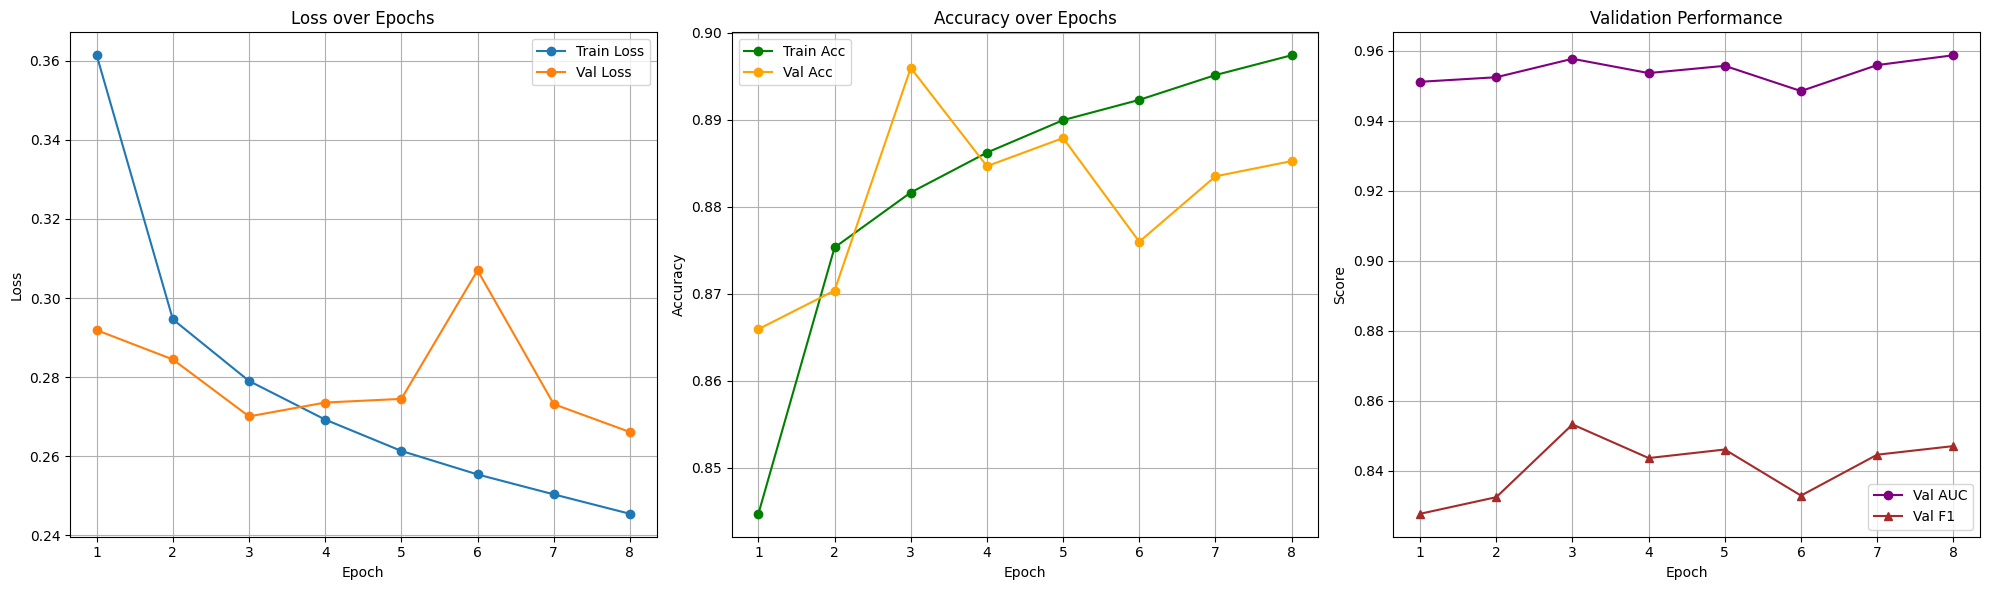

In [11]:
# === NEW Cell 9.5: Plot Comprehensive Training Curves ===
import matplotlib.pyplot as plt

epochs_range = range(1, len(history['train_loss']) + 1)

plt.figure(figsize=(20, 6))

# Plot 1: Loss (Train vs Val)
plt.subplot(1, 3, 1)
plt.plot(epochs_range, history['train_loss'], label='Train Loss', marker='o')
plt.plot(epochs_range, history['val_loss'], label='Val Loss', marker='o')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: Accuracy (Train vs Val)
plt.subplot(1, 3, 2)
plt.plot(epochs_range, history['train_acc'], label='Train Acc', marker='o', color='green')
plt.plot(epochs_range, history['val_acc'], label='Val Acc', marker='o', color='orange')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot 3: Validation Metrics (AUC & F1)
plt.subplot(1, 3, 3)
plt.plot(epochs_range, history['val_auc'], label='Val AUC', marker='o', color='purple')
plt.plot(epochs_range, history['val_f1'], label='Val F1', marker='^', color='brown')
plt.title('Validation Performance')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [12]:
# === REPLACEMENT for Cell 10: load compact checkpoint (preferred) or fallback to full ===
import os
import math
import torch
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, precision_recall_fscore_support
from torch.utils.data import DataLoader

# Ensure device is defined
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

compact_path = "/kaggle/working/best_model_weights_only.pth"
full_checkpoint_path = checkpoint_path  # This variable must exist from previous cells

# 1) Logic to load checkpoint
ckpt = None
if os.path.exists(compact_path):
    print("Loading compact weights-only checkpoint:", compact_path)
    ckpt = torch.load(compact_path, map_location=device, weights_only=False)
elif os.path.exists(full_checkpoint_path):
    print(f"Compact checkpoint not found. Falling back to full checkpoint: {full_checkpoint_path}")
    # We use weights_only=False to avoid UnpicklingError on older checkpoints
    ckpt = torch.load(full_checkpoint_path, map_location=device, weights_only=False)
else:
    raise FileNotFoundError(
        f"No checkpoint found.\n"
        f"Checked compact path: {compact_path} (Missing)\n"
        f"Checked full path: {full_checkpoint_path} (Missing)\n"
        "Please ensure you have run the training cell or pointed 'checkpoint_path' to a valid file."
    )

# 2) Extract state and load into model
# ckpt expected to contain keys: 'epoch', 'best_val_auc', 'model_state_dict'
# Some full checkpoints might wrap state_dict differently; we assume standard structure here.
if 'model_state_dict' in ckpt:
    model_state = ckpt['model_state_dict']
    start_epoch = ckpt.get('epoch', None)
    best_val_auc = ckpt.get('best_val_auc', 0.0)
else:
    # Sometimes full checkpoints ARE the state dict
    print("Warning: 'model_state_dict' key not found. Assuming checkpoint is the state dict itself.")
    model_state = ckpt
    start_epoch = None
    best_val_auc = 0.0

# Load into model (handle DataParallel)
if isinstance(model, torch.nn.DataParallel):
    model.module.load_state_dict(model_state)
else:
    model.load_state_dict(model_state)

print(f"Model loaded successfully. (Epoch={start_epoch}, Best AUC={best_val_auc})")


# 3) Evaluate on test set (image-level)
model.eval()
test_probs, test_labels = [], []

print("Running evaluation on test set...")
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        # UPDATED: compatible with newer PyTorch versions
        with torch.amp.autocast(device_type='cuda', enabled=torch.cuda.is_available()):
            logits = model(imgs)
            probs = torch.softmax(logits, dim=1)[:,1].detach().cpu().numpy()
        test_probs.extend(probs.tolist())
        test_labels.extend(labels.numpy().tolist())

test_probs = np.array(test_probs)
test_labels = np.array(test_labels)

# compute metrics
def compute_metrics_from_probs_local(probs, labels, thresh=0.5):
    if len(np.unique(labels)) > 1:
        auc = roc_auc_score(labels, probs)
    else:
        auc = float('nan')
    
    preds = (probs >= thresh).astype(int)
    acc = accuracy_score(labels, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average='binary', zero_division=0)
    return {"auc": auc, "acc": acc, "prec": prec, "recall": rec, "f1": f1}

test_metrics = compute_metrics_from_probs_local(test_probs, test_labels)
print("Test image-level metrics:", test_metrics)

# 4) Slide-level aggregation (average patch probs per slide)
test_dataset_full = HistPatchDataset(test_df, transform=val_transform)
test_loader_full = DataLoader(
    test_dataset_full, 
    batch_size=BATCH_SIZE * 2, 
    shuffle=False, 
    num_workers=NUM_WORKERS, 
    pin_memory=PIN_MEMORY
)

probs = []
print("Running slide-level aggregation...")
with torch.no_grad():
    for imgs, _ in test_loader_full:
        imgs = imgs.to(device)
        with torch.amp.autocast(device_type='cuda', enabled=torch.cuda.is_available()):
            logits = model(imgs)
            p = torch.softmax(logits, dim=1)[:,1].detach().cpu().numpy()
        probs.extend(p.tolist())

test_df_copy = test_df.copy()
test_df_copy['prob'] = probs
slide_probs = test_df_copy.groupby('slide_id')['prob'].mean().reset_index()
slide_probs['slide_label'] = slide_probs['slide_id'].map(slide_label.set_index('slide_id')['slide_class'])

if len(slide_probs['slide_label'].unique()) > 1:
    slide_auc = roc_auc_score(slide_probs['slide_label'], slide_probs['prob'])
else:
    slide_auc = float('nan')
print("Slide-level AUC:", slide_auc)

# 5) Save outputs
slide_probs.to_csv(os.path.join(WORK_DIR, "slide_level_probs.csv"), index=False)
test_df_copy[['image_path', 'prob', 'class']].to_csv(os.path.join(WORK_DIR, "image_level_probs.csv"), index=False)
print("Saved predictions to", WORK_DIR)

Loading compact weights-only checkpoint: /kaggle/working/best_model_weights_only.pth
Model loaded successfully. (Epoch=3, Best AUC=0.9576709203399207)
Running evaluation on test set...
Test image-level metrics: {'auc': 0.9459378181121468, 'acc': 0.8879801066570795, 'prec': 0.7902097902097902, 'recall': 0.8236847665328544, 'f1': 0.8066001137950654}
Running slide-level aggregation...
Slide-level AUC: 0.8939393939393938
Saved predictions to /kaggle/working


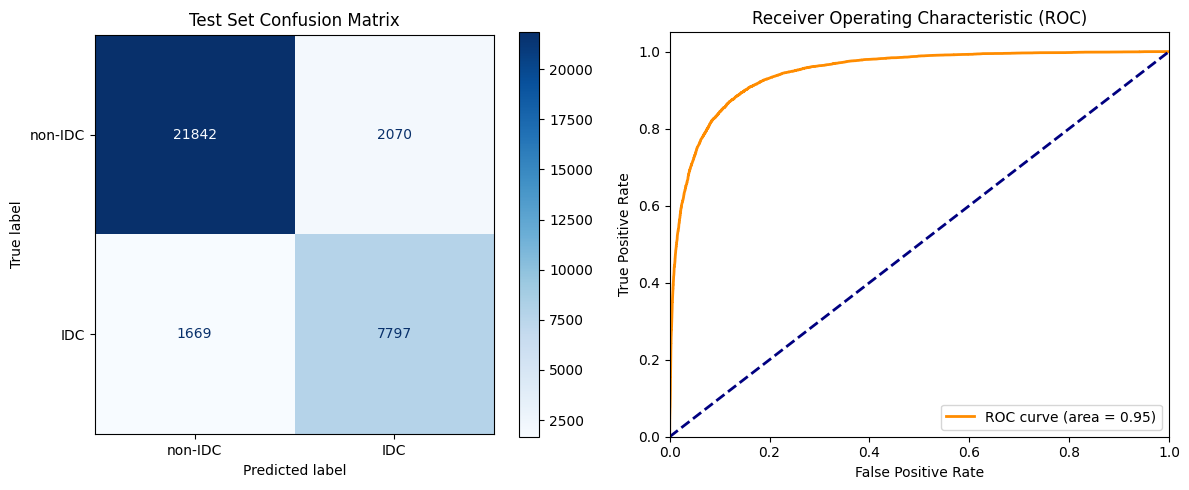

In [13]:
# === NEW Cell 12: Final Test Visualizations ===
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

# 1. Confusion Matrix
# Convert probabilities to binary predictions (threshold 0.5)
test_preds = (test_probs >= 0.5).astype(int)
cm = confusion_matrix(test_labels, test_preds)

plt.figure(figsize=(12, 5))

# Subplot 1: Confusion Matrix
plt.subplot(1, 2, 1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['non-IDC', 'IDC'])
disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
plt.title('Test Set Confusion Matrix')

# Subplot 2: ROC Curve
plt.subplot(1, 2, 2)
if len(np.unique(test_labels)) > 1:
    fpr, tpr, _ = roc_curve(test_labels, test_probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
else:
    plt.text(0.5, 0.5, "Not enough classes for ROC", ha='center')

plt.tight_layout()
plt.show()

Searching for optimal probability threshold...

>>> BEST THRESHOLD: 0.51 <<<
New F1 Score: 0.8069 (Standard was 0.8066)
Precision at best T: 0.7936
Recall at best T:    0.8206


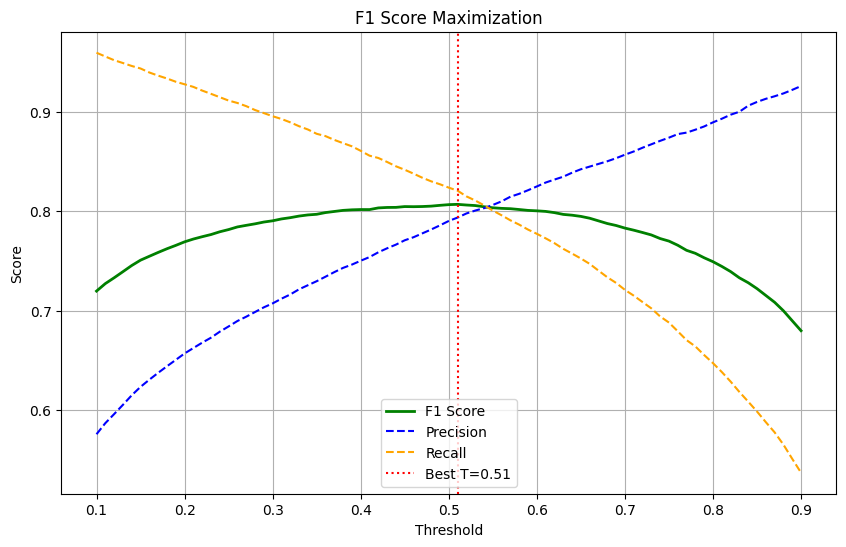

In [14]:
# === NEW Cell 13: Optimize Decision Threshold for Better F1 ===
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score

print("Searching for optimal probability threshold...")

# Try thresholds from 0.1 to 0.9
thresholds = np.arange(0.1, 0.91, 0.01)
f1_scores = []
precisions = []
recalls = []

# Calculate scores for each threshold
for t in thresholds:
    preds = (test_probs >= t).astype(int)
    f1 = f1_score(test_labels, preds)
    prec = precision_score(test_labels, preds, zero_division=0)
    rec = recall_score(test_labels, preds)
    f1_scores.append(f1)
    precisions.append(prec)
    recalls.append(rec)

# Find the threshold that gives maximum F1
best_idx = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"\n>>> BEST THRESHOLD: {best_thresh:.2f} <<<")
print(f"New F1 Score: {best_f1:.4f} (Standard was {test_metrics['f1']:.4f})")
print(f"Precision at best T: {precisions[best_idx]:.4f}")
print(f"Recall at best T:    {recalls[best_idx]:.4f}")

# Plot the trade-off curve
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1 Score', color='green', lw=2)
plt.plot(thresholds, precisions, label='Precision', color='blue', linestyle='--')
plt.plot(thresholds, recalls, label='Recall', color='orange', linestyle='--')
plt.axvline(best_thresh, color='red', linestyle=':', label=f'Best T={best_thresh:.2f}')
plt.title("F1 Score Maximization")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()